## Exercicio para detectar Nombres de Dominios Generados Algorítmicamente.
En este notebook vamos a utilizar varios de los módulos de Python para explorar, analizar y clasificar dominios dentro de una de dos posibles clases: (1) 'legítimos' o (2) 'dga', aquellos con una gran probabilidad de haber sido generados con un DGA (algoritmo de generación dinámica de dominios). Nuestra definición de 'legítimos' se basa en la lista de dominios publicados por Alexa, que consiste en los dominios más populares, de acuerdo al tráfico que generan.

La principal motivación de este notebook es mostrar las posibilidades que permiten Jupyter Notebook (IPython), Pandas, scikit-learn y Matplotlib para lograr la detección de dominios DGA. El ejercicio mostrado aquí, incluye de forma intencional intentos fallidos y errores durante la identificación de un mecanismo para detectar dominios DGA, así como resultados que definitivamente pueden ser mejorados. En general, al capturar que funcionó, así como que no funcionó, mostramos un escenario más realista e informativo. :)

**NOTA**
**Este notebook es una traducción al español de la colección de Jupyter notebooks creados por Click Security. La colección está disponible en http://clicksecurity.github.io/data_hacking/**

### Principales Módulos de Python Usados en este Notebook:
- Pandas: Python Data Analysis Library (http://pandas.pydata.org)
- Scikit Learn (http://scikit-learn.org) Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
- Matplotlib:  Python 2D plotting library (http://matplotlib.org)

**Sugerencias/Comentarios:**
Por favor envie sugerencias o errores identificados a *clicklabs at clicksecurity.com*. Adicionalmente, contáctenos si usted tiene algún dataset o técnicas alternativas para explorar estos problemas.

Todos los comentarios, sugerencias o errores identificados por la traducción al español pueden ser enviados a gaspar@acm.org.

Instalar librería tldextract conda install -c conda-forge tldextract

In [1]:
# Cargando las librerías necesarias
import numpy as np
import sklearn.feature_extraction
import sklearn.ensemble            # librería de algorítmos de conjuntos 
import pylab
import matplotlib.pyplot as plt
import tldextract                  # librería para manejar nombres de dominios
sklearn.__version__                # para mostrar la versión instalada de la librería

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


ModuleNotFoundError: No module named 'tldextract'

In [2]:
import pandas as pd
pd.__version__                     # para mostrar la versión instalada de la librería

'0.23.4'

In [3]:
# Configurar pylab para visualización que realizaremos más adelante
pylab.rcParams['figure.figsize'] = (14.0, 5.0)
pylab.rcParams['axes.grid'] = True

In [4]:
# Buscando ignorar mensajes de DeprecationWarning que usualmente aparecen en Pandas
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
# Esta es la lista de los primeros 100k dominios según Alexa. No utilizamos la lista completa, de 1M,
# por razones de velocidad. Pero si quieres probar, la lista completa esta disponible en el directorio
# data (en formato comprimido 7z)
alexa_dataframe = pd.read_csv('data/alexa_100k.csv', names=['rank','uri'], header=None, encoding='utf-8')
alexa_dataframe.head()

FileNotFoundError: File b'data/alexa_100k.csv' does not exist

In [6]:
# Crear funcion para extraer el segundo nivel del dominio (2LD)
def domain_extract(uri):
    ext = tldextract.extract(uri)
     
    if (not ext.suffix):
        return np.nan
    else:
        return ext.domain
alexa_dataframe['domain'] = [domain_extract(uri) for uri in alexa_dataframe['uri']]
del alexa_dataframe['rank']
del alexa_dataframe['uri']
alexa_dataframe.head()            # esta funcion permite ver las primeras lineas del dataframe

NameError: name 'alexa_dataframe' is not defined

In [7]:
alexa_dataframe.tail()            # esta función permite ver las últimas líneas del dataframe

NameError: name 'alexa_dataframe' is not defined

In [8]:
# Eliminar aquellas líneas con NaNs y líneas duplicadas
alexa_dataframe = alexa_dataframe.dropna()
alexa_dataframe = alexa_dataframe.drop_duplicates()

# Añadir la columna con la clase de las muestras
alexa_dataframe['class'] = 'legit'

# Barajar los datos (importante para crear los sets de entrenamiento y evaluación)
alexa_dataframe = alexa_dataframe.reindex(np.random.permutation(alexa_dataframe.index))
alexa_total = alexa_dataframe.shape[0]
print('Número Total de Dominios Alexa: %d' % alexa_total)

# Mantener el 10% de los datos para evaluación (hold out)
cutoff = int(alexa_total*.9)
hold_out_alexa = alexa_dataframe[cutoff:]
alexa_dataframe = alexa_dataframe[:cutoff]

print('Número de Dominios Alexa para Entrenamiento: %d' % alexa_dataframe.shape[0])

Número Total de Dominios Alexa: 91377
Número de Dominios Alexa para Entrenamiento: 82239


In [9]:
alexa_dataframe

domain  class
5740       alexaboostup  legit
99998        nahimunkar  legit
87174      thelinkworld  legit
31223          codecall  legit
72826       kingdomrush  legit
37090   dailytvtorrents  legit
38662         applegate  legit
2238         superpages  legit
39958        com-promos  legit
28311               aip  legit
52309          ishopper  legit
92317   ca-franchecomte  legit
96675          imagenar  legit
37095           itopdog  legit
4873               muzy  legit
89284            hitvid  legit
21253         excelhome  legit
24246          newswire  legit
76509        metasploit  legit
85904           dopdemo  legit
9436         sciencemag  legit
15211           vikatan  legit
48649         slowrobot  legit
7013           legendas  legit
32538          webtowns  legit
55560        beyondmenu  legit
97573         fotkidepo  legit
34540   famouspornstars  legit
4441              heavy  legit
72361          unotelly  legit
...                 ...    ...
86692           ziye114  legit
9216        mobypicture  legit
61946          funfunky  legit
44228             hair8  legit
73653           lolblog  legit
75606           live-pr  legit
6274              dhnet  legit
32462         ra-market  legit
94695           gaghome  legit
49627         dead-surf  legit
85769      blockbuzzing  legit
81436             sf920  legit
55802         topbiz360  legit
18825      manageengine  legit
83808          cimbbank  legit
233            download  legit
82522          newgames  legit
1406                mbc  legit
17578  raiffeisendirect  legit
1866           moonbasa  legit
52775   catholiccompany  legit
8321    donya-e-eqtesad  legit
50136      enfordummies  legit
96811               bea  legit
76804        ab-archive  legit
22332           letsrun  legit
60802    publicisgroupe  legit
75244      flash-screen  legit
29887            qiyeku  legit
2614         realitatea  legit

[82239 rows x 2 columns]

In [10]:
alexa_dataframe.head()

domain  class
5740   alexaboostup  legit
99998    nahimunkar  legit
87174  thelinkworld  legit
31223      codecall  legit
72826   kingdomrush  legit

In [11]:
# Crear dataframe que contiene los dominios DGA
dga_dataframe = pd.read_csv('data/dga_domains.txt', names=['raw_domain'], header=None, encoding='utf-8')

# Necesario normalizar los dominios ya que algunos sólo difieren por capitalización o .com/.org/.info
dga_dataframe['domain'] = dga_dataframe.applymap(lambda x: x.split('.')[0].strip().lower())
del dga_dataframe['raw_domain']

# Eliminar aquellas lineas con NaNs y lineas duplicadas
dga_dataframe = dga_dataframe.dropna()
dga_dataframe = dga_dataframe.drop_duplicates()
dga_total = dga_dataframe.shape[0]
print('Número Total de Dominios DGA: %d' % dga_total)

# Añadir la columna con la clase de las muestras
dga_dataframe['class'] = 'dga'

# Mantener el 10% de los datos para evaluación (hold out)
cutoff_dga = int(dga_total*.9)
hold_out_dga = dga_dataframe[cutoff_dga:]
dga_dataframe = dga_dataframe[:cutoff_dga]

print('Número de Dominios DGA para Entrenamiento: %d' % dga_dataframe.shape[0])

Número Total de Dominios DGA: 2664
Número de Dominios DGA para Entrenamiento: 2397


In [12]:
dga_dataframe.head()

domain class
0  04055051be412eea5a61b7da8438be3d   dga
1                        1cb8a5f36f   dga
2  30acd347397c34fc273e996b22951002   dga
3  336c986a284e2b3bc0f69f949cb437cb   dga
5  40a43e61e56a5c218cf6c22aca27f7ee   dga

In [13]:
# Concatenar los dos archivos de entrenamiento
all_domains = pd.concat([alexa_dataframe, dga_dataframe], ignore_index=True)

In [14]:
# Añadir una columna de longitud para los dominios
all_domains['length'] = [len(x) for x in all_domains['domain']]

# Tomamos la decisión de remover los dominios con longitud de hasta 6 caracteres,
# ya que hemos observado que estos no siguen nuestra idea de que los dominios
# DGA típicamente poseen una longitud mayor. Debido a esta decisión, nos estamos
# forzando a probablemente crear listas (white/black lists) para dominios cortos
all_domains = all_domains[all_domains['length'] > 6]

In [15]:
# Función tomada de Rosetta Code (rosettacode.org)
import math
from collections import Counter
 
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

In [16]:
# Añadir una columna de entropía para los dominios
all_domains['entropy'] = [entropy(x) for x in all_domains['domain']]

In [17]:
all_domains.head()

domain  class  length   entropy
0  alexaboostup  legit      12  3.251629
1    nahimunkar  legit      10  2.921928
2  thelinkworld  legit      12  3.418296
3      codecall  legit       8  2.500000
4   kingdomrush  legit      11  3.459432

In [18]:
all_domains.tail()

domain class  length   entropy
84631  ulxxqduryvv   dga      11  2.913977
84632     ummvzhin   dga       8  2.750000
84633     umsgnwgc   dga       8  2.750000
84634  umzsbhpkrgo   dga      11  3.459432
84635  umzuyjrfwyf   dga      11  2.913977

## Hora de Graficar (Detectar patrones y distribución de los datos)

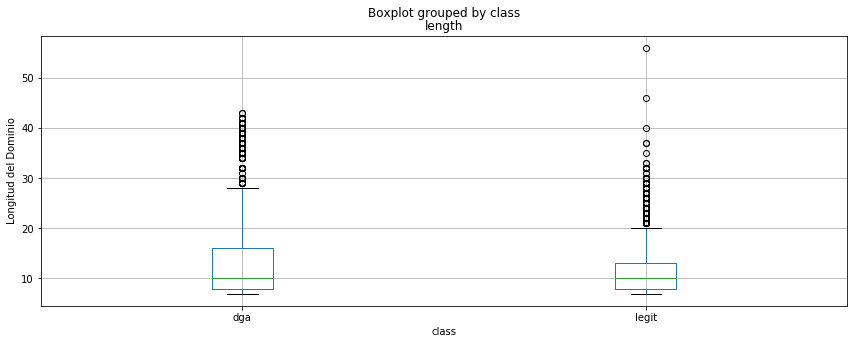

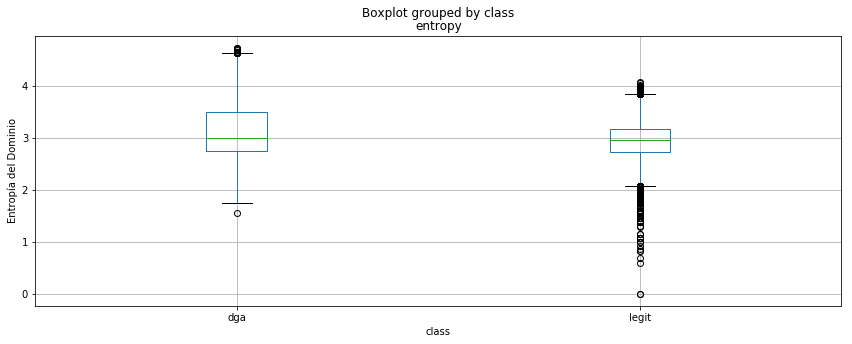

In [19]:
# El diagrama de caja (boxplots) muestra la distribución de los datos (propagación)
# https://es.wikipedia.org/wiki/Diagrama_de_caja

# Graficar la longitud y entropía de los dominios
all_domains.boxplot('length','class')
pylab.ylabel('Longitud del Dominio')
all_domains.boxplot('entropy','class')
pylab.ylabel('Entropía del Dominio')
plt.show()

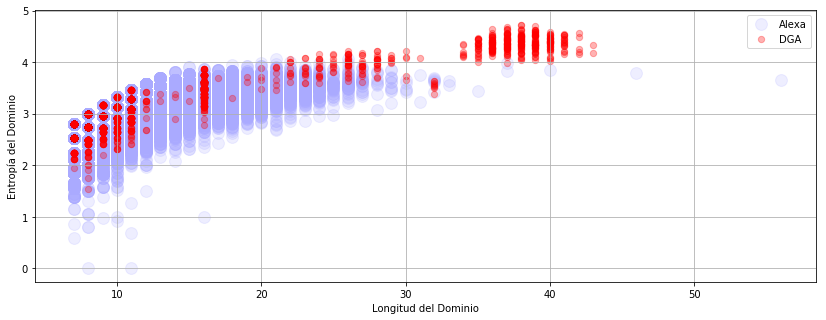

In [20]:
# Dividir las clases para poder establecer colores, tamaño y etiquetas de las muestras
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
alexa = all_domains[~cond]
plt.scatter(alexa['length'], alexa['entropy'], s=140, c='#aaaaff', label='Alexa', alpha=.2)
plt.scatter(dga['length'], dga['entropy'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
pylab.xlabel('Longitud del Dominio')
pylab.ylabel('Entropía del Dominio')
plt.show()
# Se aprecia que en promedio, los dominios DGA tienden a mostrar mayor entropía que los de Alexa

In [21]:
# Veámos aquellos dominios que poseen una entropía mayor a 4
high_entropy_domains = all_domains[all_domains['entropy'] > 4]
print('No. Dominios con Entropía > 4: %.2f%% %d (de un total de %d)' % (100.0*high_entropy_domains.shape[0]/all_domains.shape[0],high_entropy_domains.shape[0],all_domains.shape[0]))
print("No. Dominios Legítimos con Alta Entropía: %d" % high_entropy_domains[high_entropy_domains['class']=='legit'].shape[0])
print("No. Dominios DGA con Alta Entropía: %d" % high_entropy_domains[high_entropy_domains['class']=='dga'].shape[0])
high_entropy_domains[high_entropy_domains['class']=='legit'].head()

# Los resultados de abajo muestran que hay más dominios en el grupo DGA
# con alta entropía, pero sólo un pequeño porcentaje de todos los dominios
# DGA poseen alta entropía

No. Dominios con Entropía > 4: 0.57% 361 (de un total de 62998)
No. Dominios Legítimos con Alta Entropía: 3
No. Dominios DGA con Alta Entropía: 358


domain  class  length   entropy
3574       burzhunetdlyachaynikov  legit      22  4.004886
21716       theukwebdesigncompany  legit      21  4.070656
73829  congresomundialjjrperu2009  legit      26  4.056021

In [22]:
high_entropy_domains[high_entropy_domains['class']=='dga'].head()

domain class  length   entropy
82257      a17btkyb38gxe41pwd50nxmzjxiwjwdwfrp52   dga      37  4.540402
82258    a17c49l68ntkqnuhvkrmyb28fubvn30e31g43dq   dga      39  4.631305
82259      a17d60gtnxk47gskti15izhvlviyksh64nqkz   dga      37  4.270132
82260     a17erpzfzh64c69csi35bqgvp52drita67jzmy   dga      38  4.629249
82261  a17fro51oyk67b18ksfzoti55j36p32o11fvc29cr   dga      41  4.305859

In [23]:
# En preparación para usar scikit-learn, vamos a convertir las 
# estructuras de datos de Panda, a formato para scikit (np-array)

# Matriz con vectores de muestras (scikit learn usa la convención 'X' como nombre de la matriz de muestras)
X = all_domains.as_matrix(['length', 'entropy'])

# Etiquetas (usamos la convención 'y' para etiquetas de las clases)
y = np.array(all_domains['class'].tolist()) # Yes, this is weird but it needs 
                                            # to be an np.array of strings

/Users/hdemercado/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [24]:
# Random Forest es un popular clasificador de aprendizaje de máquinas, de método de conjunto (ensemble)
# http://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestClassifier.html
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20) # Número de arboles en la foresta

In [25]:
#https://scikit-learn.org/stable/modules/cross_validation.html

In [26]:
# Utilizamos los métodos de validación cruzada de scikit-learn para estimar el rendimiento
# predictivo del modelo Random Forest
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5, n_jobs=4)
print(scores)

[0.96873264 0.96873016 0.96960076 0.96817208 0.96404477]


Precisión de 96%! lo logramos o no? Si creemos que triunfamos, estaríamos ignorando
un factor muy importante. La data está bien desbalanceada. Tenemos cerca de 100k dominios
legítimos y sólo 3.5k dominios DGA. Por lo que un clasificador que determine toda muestra
como legítima, tendría también una precisión aproximada de 96%.

In [27]:
# Debemos hacer un análisis más profundo del rendimiento del clasificador

# Dividimos la data en 80% para entrenamiento y 20% para evaluación (80/20 split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Estadísticas de la Matriz de Confusión
legit/legit: 99.83% (12083/12103)
legit/dga: 0.17% (20/12103)
dga/legit: 80.89% (402/497)
dga/dga: 19.11% (95/497)


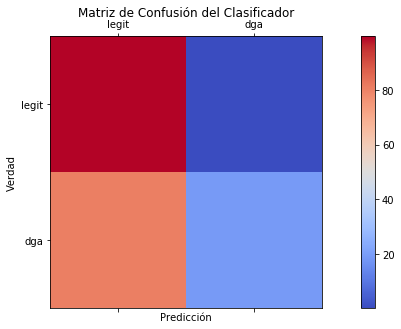

In [28]:
# Ahora graficamos los resultados de la data 80/20 en una matriz de confusión
from sklearn.metrics import confusion_matrix
labels = ['legit', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)

def plot_cm(cm, labels):
    
    # Calcular los porcentajes
    percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T)  # Derp, I'm sure there's a better way
    
    print('Estadísticas de la Matriz de Confusión')
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print("%s/%s: %.2f%% (%d/%d)" % (label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum()))

    # Mostrar la matriz de confusión
    # Thanks kermit666 from stackoverflow :)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='coolwarm')
    pylab.title('Matriz de Confusión del Clasificador')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    pylab.xlabel('Predicción')
    pylab.ylabel('Verdad')
    pylab.show()

plot_cm(cm, labels)
# https://en.wikipedia.org/wiki/Confusion_matrix

# Ahora vemos que nuestras sospechas eran correctas y que el clasificador
# está marcando casi todos las muestras como legítimas. Hemos fallado... 
# la ciencia es dura... hora de tomar una cerveza...

In [29]:
# Recibimos apoyo de nuestra madre por lo que continuaremos y ahora
# calcularemos NGrams para cada dominio 'legítimo' y veremos si podemos
# usar NGrams para ayudarnos a diferenciar y detectar dominios DGA...

# Scikit-learn brinda un buen generador de NGrams que puede crear NGrams de 
# caracteres o NGrams de palabras. Usaremos de caracteres.
# Parámetros:
#       - ngram_range=(3,5)  # Produce todos los ngrams de longitud 3, 4, y 5
#       - min_df=1e-4        # Mínima frecuencia de documentos. Usar 1e-4 estamos
#                            # diciendo que deseamos obtener NGrams que han
#                            # ocurrido en al menos el .1% de los dominios
#                            # (para 100k dominios, son al menos 100)
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
alexa_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-4, max_df=1.0)

In [30]:
# Existe una mejor manera de almacenar todos los conteos...
# Al menos el parámetro min_df produce algunos recortes (thresholding)
counts_matrix = alexa_vc.fit_transform(alexa_dataframe['domain'])
alexa_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = alexa_vc.get_feature_names()

In [31]:
# Ordenemos los NGrams y mostrémoslos
import operator
_sorted_ngrams = sorted(zip(ngrams_list, alexa_counts), key=operator.itemgetter(1), reverse=True)
print('Alexa NGrams: %d' % len(_sorted_ngrams))
for ngram, count in _sorted_ngrams[:10]:
    print(ngram, count)

Alexa NGrams: 23907
ing 3.392696953259666
lin 3.3783979009481375
ine 3.3554515201265174
tor 3.2219355998280053
ter 3.216429830876251
ion 3.2030328870147105
ent 3.1835545336188615
por 3.157456768134226
the 3.1513698502474603
ree 3.1192558892779365


In [32]:
# Vamos a crear un dataframe con palabras de un diccionario
word_dataframe = pd.read_csv('data/words.txt', names=['word'], header=None, dtype={'word': np.str}, encoding='utf-8')

# Limpiar palabras del diccionario
word_dataframe = word_dataframe[word_dataframe['word'].map(lambda x: str(x).isalpha())]
word_dataframe = word_dataframe.applymap(lambda x: str(x).strip().lower())
# https://help.qlik.com/es-ES/sense/June2018/Subsystems/Hub/Content/Scripting/MappingFunctions/ApplyMap.htm
word_dataframe = word_dataframe.dropna()
word_dataframe = word_dataframe.drop_duplicates()
word_dataframe.head(10)

word
37       a
48      aa
51     aaa
53    aaaa
54  aaaaaa
55    aaal
56    aaas
57  aaberg
58  aachen
59     aae

In [33]:
# Ahora calculemos NGrams sobre las palabras del diccionario
# Igual proceso al de arriba
dict_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-5, max_df=1.0)
counts_matrix = dict_vc.fit_transform(word_dataframe['word'])
dict_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = dict_vc.get_feature_names()
#https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.log10.html

In [34]:
# Ordenemos los NGrams y mostrémoslos
_sorted_ngrams = sorted(zip(ngrams_list, dict_counts), key=operator.itemgetter(1), reverse=True)
print('Word NGrams: %d' % len(_sorted_ngrams))
for ngram, count in _sorted_ngrams[:10]:
    print(ngram, count)

Word NGrams: 123061
ing 4.387300822448285
ess 4.204879333760662
ati 4.1933472563864616
ion 4.165036479994566
ter 4.162415036106447
nes 4.112504458767161
tio 4.076822423342773
ate 4.0723602039634885
ent 4.069631102620343
tion 4.0496056125949735


In [35]:
# Usamos el método transform de la clase CountVectorizer para crear un
# vector de ngrams que existen en el dominio. El vector luego es multiplicado
# por el vector count (el cual es una suma por columna de la matriz count)
def ngram_count(domain):
    alexa_match = alexa_counts * alexa_vc.transform([domain]).T  # Woot vector multiply and transpose Woo Hoo!
    dict_match = dict_counts * dict_vc.transform([domain]).T
    print('{0:25s} - Alexa match:{1:3d} - Dict match:{2:3d}'.format(domain, int(alexa_match), int(dict_match)))

# Examples:
ngram_count('google')
ngram_count('facebook')
ngram_count('1cb8a5f36f')
ngram_count('pterodactylfarts')
ngram_count('ptes9dro-dwacty2lfa5rrts')
ngram_count('beyonce')
ngram_count('bey666on4ce')

google                    - Alexa match: 17 - Dict match: 14
facebook                  - Alexa match: 30 - Dict match: 27
1cb8a5f36f                - Alexa match:  0 - Dict match:  0
pterodactylfarts          - Alexa match: 33 - Dict match: 76
ptes9dro-dwacty2lfa5rrts  - Alexa match: 19 - Dict match: 28
beyonce                   - Alexa match: 15 - Dict match: 16
bey666on4ce               - Alexa match:  2 - Dict match:  1


In [36]:
# Calcular los pareos NGram para todos los dominios y añadir al dataframe
all_domains['alexa_grams']= alexa_counts * alexa_vc.transform(all_domains['domain']).T 
all_domains['word_grams']= dict_counts * dict_vc.transform(all_domains['domain']).T 
all_domains.head()

domain  class  length   entropy  alexa_grams  word_grams
0  alexaboostup  legit      12  3.251629    33.606082   43.919569
1    nahimunkar  legit      10  2.921928    16.509424   23.640120
2  thelinkworld  legit      12  3.418296    49.848327   52.982407
3      codecall  legit       8  2.500000    24.645723   36.814432
4   kingdomrush  legit      11  3.459432    30.903572   35.963233

In [37]:
all_domains.tail()

domain class  length   entropy  alexa_grams  word_grams
84631  ulxxqduryvv   dga      11  2.913977     3.727623    6.464859
84632     ummvzhin   dga       8  2.750000     6.137398    7.180022
84633     umsgnwgc   dga       8  2.750000     3.211654    3.847079
84634  umzsbhpkrgo   dga      11  3.459432     1.633468    2.546543
84635  umzuyjrfwyf   dga      11  2.913977     0.000000    0.000000

In [38]:
# Usar las operaciones vectorizadas del dataframe para investigar las diferencias
# entre los grams de alexa y los de las palabras
all_domains['diff'] = all_domains['alexa_grams'] - all_domains['word_grams']
all_domains.sort_values(['diff'], ascending=True).head(10)

# La tabla de abajo muestra aquellos nombres de dominio que son parecidos a
# el diccionario y menos al web

domain  class  length   entropy  alexa_grams  \
6793     stirringtroubleinternationally  legit      30  3.481728   130.920021   
40798     channel4embarrassingillnesses  legit      29  3.440070    93.732429   
32028  bipolardisorderdepressionanxiety  legit      32  3.616729   115.762046   
73555  americansforresponsiblesolutions  legit      32  3.667838   144.982172   
79405               pragmatismopolitico  legit      19  3.326360    59.686583   
72777            foreclosurephilippines  legit      22  3.447402    71.396713   
22607           egaliteetreconciliation  legit      23  3.186393    91.144824   
21959           interoperabilitybridges  legit      23  3.588354    93.140666   
82494        canadianpharmaceuticalsorg    dga      26  3.690260    83.069332   
22960         corazonindomablecapitulos  legit      25  3.813661    74.092068   

       word_grams       diff  
6793   207.204729 -76.284708  
40798  169.119440 -75.387011  
32028  190.833856 -75.071810  
73555  218.363956 -73.381784  
79405  121.536223 -61.849639  
72777  132.514638 -61.117926  
22607  152.125325 -60.980502  
21959  153.626312 -60.485646  
82494  143.316082 -60.246750  
22960  133.160690 -59.068622

In [39]:
all_domains.sort_values(['diff'], ascending=False).head(20)

# La tabla de abajo muestra aquellos nombres de dominio que son más tipo web y menos
# de diccionario...

domain  class  length  \
23161  gay-sex-pics-porn-pictures-gay-sex-porn-gay-se...  legit      56   
45333     article-directory-free-submission-free-content  legit      46   
52063                          stream-free-movies-online  legit      25   
53547                          best-online-shopping-site  legit      25   
29331                            watch-free-movie-online  legit      23   
7160                       free-links-articles-directory  legit      29   
30039                              free-online-directory  legit      21   
59319                               online-web-directory  legit      20   
19644                      social-bookmarking-sites-list  legit      29   
79270                            freegamesforyourwebsite  legit      23   
31586                                xxx-porno-sexvideos  legit      19   
76848                               web-directory-online  legit      20   
26608                                  movie-news-online  legit      17   
31637                               free-tv-video-online  legit      20   
2270                               seowebdirectoryonline  legit      21   
69185                                download-free-games  legit      19   
22939                             free-web-mobile-themes  legit      22   
26841                            web-link-directory-site  legit      23   
39159                         freeweb-directory-listings  legit      26   
3434                             social-bookmarking-site  legit      23   

        entropy  alexa_grams  word_grams       diff  
23161  3.661056   155.207919   85.124184  70.083734  
45333  3.786816   232.955935  188.230453  44.725482  
52063  3.509275   118.971117   74.496915  44.474202  
53547  3.452879   121.892484   79.596640  42.295844  
29331  3.708132   101.040419   58.943451  42.096968  
7160   3.702472   151.758794  110.955361  40.803433  
30039  3.403989   121.432825   80.735030  40.697795  
59319  3.584184   113.967057   74.082948  39.884108  
19644  3.702472   141.625836  102.261826  39.364010  
79270  3.551191   115.797830   77.311761  38.486070  
31586  3.260828    72.921856   34.574489  38.347367  
76848  3.584184   112.301340   74.082948  38.218391  
26608  3.175123    79.789752   41.705735  38.084017  
31637  3.284184    83.563498   45.662984  37.900514  
2270   3.499228   126.019302   91.819498  34.199804  
69185  3.576618    84.644194   50.661490  33.982704  
22939  3.356492    87.962063   54.149725  33.812338  
26841  3.729446   102.150506   69.367186  32.783320  
39159  3.796218   148.261027  115.541450  32.719577  
3434   3.762267   116.613490   83.942961  32.670529

Text(0,0.5,'No. de Coincidencias con Alexa NGrams')

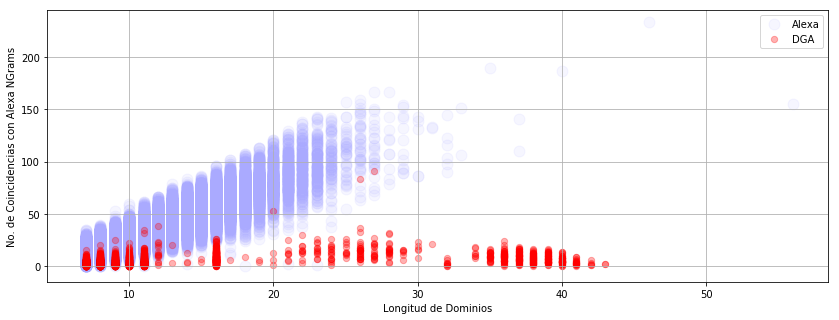

In [40]:
# Vamos a graficar
# Aquí deseamos ver si nuestra característica alexa_grams puede ayudarnos a diferenciar
# entre legítimo y DGA
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]
plt.scatter(legit['length'], legit['alexa_grams'], s=120, c='#aaaaff', label='Alexa', alpha=.1)
plt.scatter(dga['length'], dga['alexa_grams'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
pylab.xlabel('Longitud de Dominios')
pylab.ylabel('No. de Coincidencias con Alexa NGrams')

Text(0,0.5,'No. de Coincidencias con Alexa NGrams')

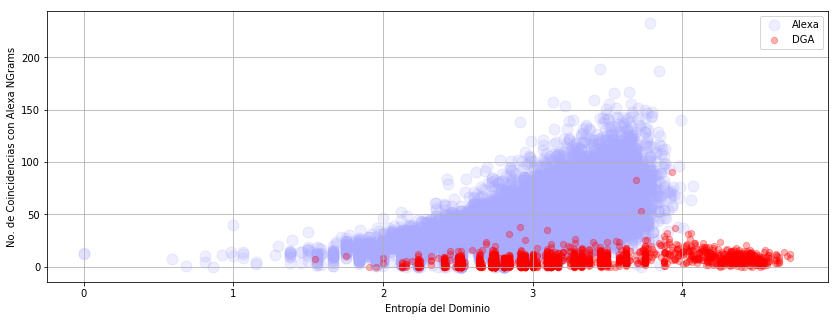

In [41]:
# Vamos a graficar
# Aquí deseamos ver si nuestra característica alexa_grams puede ayudarnos a diferenciar
# entre legítimo y DGA
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]
plt.scatter(legit['entropy'], legit['alexa_grams'],  s=120, c='#aaaaff', label='Alexa', alpha=.2)
plt.scatter(dga['entropy'], dga['alexa_grams'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
pylab.xlabel('Entropía del Dominio')
pylab.ylabel('No. de Coincidencias con Alexa NGrams')

Text(0,0.5,'No. de Coincidencias con NGrams tipo Diccionario')

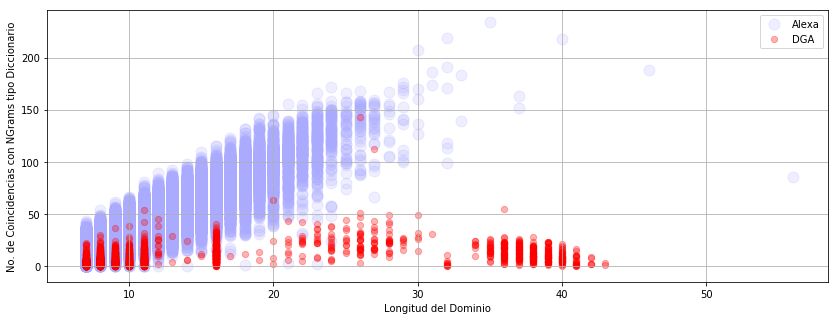

In [42]:
# Vamos a graficar
# Aquí deseamos ver si nuestra característica word_grams puede ayudarnos a diferenciar
# entre legítimo y DGA
# Nota: no luce tan bien como en el caso de los Alexa_grams pero puede que generalize mejor (menos overfit)

cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]
plt.scatter(legit['length'], legit['word_grams'],  s=120, c='#aaaaff', label='Alexa', alpha=.2)
plt.scatter(dga['length'], dga['word_grams'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
pylab.xlabel('Longitud del Dominio')
pylab.ylabel('No. de Coincidencias con NGrams tipo Diccionario')

In [43]:
# Veámos cuales dominios legítimos poseen una puntuación baja en el conteo de word grams
all_domains[(all_domains['word_grams']==0)].head()

domain  class  length   entropy  alexa_grams  word_grams      diff
550     fz12345  legit       7  2.807355     4.416341         0.0  4.416341
1379  123456790  legit       9  3.169925     6.370583         0.0  6.370583
2357    4390208  legit       7  2.521641     0.000000         0.0  0.000000
3104    8884321  legit       7  2.128085     2.643453         0.0  2.643453
3538    0597tbw  legit       7  2.807355     2.113943         0.0  2.113943

In [44]:
# Lucen raros los resultados, utilicemos funciones de Pandas
# para producir varias estadísticas sobre las nuevas características
all_domains[all_domains['class']=='legit'].describe()

length       entropy   alexa_grams    word_grams          diff
count  60601.000000  60601.000000  60601.000000  60601.000000  60601.000000
mean      10.870745      2.930541     32.760912     40.746095     -7.985183
std        3.390904      0.346459     19.159436     23.248115      9.447554
min        7.000000     -0.000000      0.000000      0.000000    -76.284708
25%        8.000000      2.725481     18.826102     23.943518    -13.140504
50%       10.000000      2.947703     28.407409     36.087873     -7.249222
75%       13.000000      3.169925     42.094167     52.862418     -2.087981
max       56.000000      4.070656    232.955935    233.648571     70.083734

Text(0,0.5,'Valor NGram Máximo')

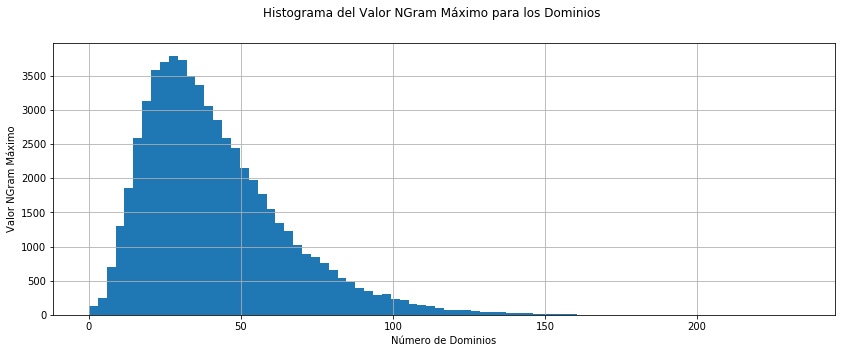

In [45]:
# Veámos cuantos dominios legítimos poseen valores bajos en word_grams y alexa_grams (graficando sólo el valor máximo
# entre ellos)
legit = all_domains[(all_domains['class']=='legit')]
max_grams = np.maximum(legit['alexa_grams'],legit['word_grams'])
ax = max_grams.hist(bins=80)
ax.figure.suptitle('Histograma del Valor NGram Máximo para los Dominios')
pylab.xlabel('Número de Dominios')
pylab.ylabel('Valor NGram Máximo')

In [46]:
# Veámos cuantos dominios legítimos poseen valores bajos en word_grams y alexa_grams (graficando sólo el valor máximo
# entre ellos)
weird_cond = (all_domains['class']=='legit') & (all_domains['word_grams']<3) & (all_domains['alexa_grams']<2)
weird = all_domains[weird_cond]
print(weird.shape[0])
weird.head(30)

82


domain  class  length   entropy  alexa_grams  \
2357                   4390208  legit       7  2.521641     0.000000   
4071                   sndmktg  legit       7  2.807355     1.819544   
4580                   0204321  legit       7  2.235926     1.000000   
5343                  d20pfsrd  legit       8  2.750000     0.000000   
7333                   1532888  legit       7  2.128085     1.643453   
7747                   ih8sn0w  legit       7  2.807355     0.000000   
9053                   fzysqmy  legit       7  2.521641     1.146128   
9242                 757207049  legit       9  2.419382     0.000000   
11009                  520e314  legit       7  2.807355     1.113943   
11989                  x264-bb  legit       7  2.521641     1.000000   
13959                  9995432  legit       7  2.128085     1.414973   
14798                  sk44261  legit       7  2.521641     0.000000   
14878                  hljdns4  legit       7  2.807355     1.707570   
15573       xn--12clb9joa5dc2o  legit      18  3.725481     0.000000   
18525                  6470355  legit       7  2.521641     0.000000   
19906  xn--42cgk1gc8crdb1htg3d  legit      23  3.849224     1.322219   
20208                  aek1924  legit       7  2.807355     0.000000   
21289                  r4i-3ds  legit       7  2.807355     0.000000   
23719                  enwdgts  legit       7  2.807355     1.591065   
24073                  5278bbs  legit       7  2.521641     1.785330   
24994                  qq66699  legit       7  1.556657     1.322219   
25024                 ylbxglzx  legit       8  2.500000     0.000000   
25351                  zszywka  legit       7  2.521641     0.000000   
25566                  ln12582  legit       7  2.521641     1.079181   
28229                  woai310  legit       7  2.807355     1.176091   
29220                  jdypgxw  legit       7  2.807355     1.000000   
29772                  zgqmbbs  legit       7  2.521641     1.785330   
30313                 bjltwybj  legit       8  2.500000     0.000000   
30545                  shzxgov  legit       7  2.807355     1.653213   
30665                mmmppp333  legit       9  1.584963     1.342423   

       word_grams      diff  
2357     0.000000  0.000000  
4071     2.049218 -0.229674  
4580     0.000000  1.000000  
5343     0.000000  0.000000  
7333     0.000000  1.643453  
7747     0.000000  0.000000  
9053     0.000000  1.146128  
9242     0.000000  0.000000  
11009    0.000000  1.113943  
11989    0.000000  1.000000  
13959    0.000000  1.414973  
14798    0.000000  0.000000  
14878    0.000000  1.707570  
15573    1.397940 -1.397940  
18525    0.000000  0.000000  
19906    2.411620 -1.089400  
20208    0.000000  0.000000  
21289    0.000000  0.000000  
23719    2.164353 -0.573288  
24073    1.322219  0.463111  
24994    0.000000  1.322219  
25024    1.146128 -1.146128  
25351    0.698970 -0.698970  
25566    0.000000  1.079181  
28229    2.260071 -1.083980  
29220    1.462398 -0.462398  
29772    1.322219  0.463111  
30313    2.167317 -2.167317  
30545    2.000000 -0.346787  
30665    1.982271 -0.639849

In [47]:
# Epifanía... Alexa puede que no sea el mejor set de ejemplos...
#             (probablemente un momento nada sorpresa para todos :)
#
# Discusión:  Si usamos estas muestras como ejemplos de NOT DGA, estamos
#             probablemente haciendo las cosas duras para el algorítmo de ML.
#             Tal vez, debamos tener dos categorías de dominios Alexa, legítimo
#             y weird. Basado en alguna definición de weird, tenemos aproximadamente
#             80 dominios.
#
all_domains.loc[weird_cond, 'class'] = 'weird'
print(all_domains['class'].value_counts())
all_domains[all_domains['class'] == 'weird'].head()

legit    60519
dga       2397
weird       82
Name: class, dtype: int64


domain  class  length   entropy  alexa_grams  word_grams      diff
2357   4390208  weird       7  2.521641     0.000000    0.000000  0.000000
4071   sndmktg  weird       7  2.807355     1.819544    2.049218 -0.229674
4580   0204321  weird       7  2.235926     1.000000    0.000000  1.000000
5343  d20pfsrd  weird       8  2.750000     0.000000    0.000000  0.000000
7333   1532888  weird       7  2.128085     1.643453    0.000000  1.643453

In [48]:
# Ahora vamos a utilizar nuestro algorítmo de ML nuevamente con las
# nuevas características Alexa y Dictionary NGrams y la exclusión de 
# las muestras weird.
X = all_domains.as_matrix(['length', 'entropy', 'alexa_grams', 'word_grams'])

# Etiquetas (scikit-learn utiliza y como etiquetas de clasificación)
y = np.array(all_domains['class'].tolist())

# Entrenar el modelo con un split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

/Users/hdemercado/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Estadísticas de la Matriz de Confusión
legit/legit: 99.56% (12038/12091)
legit/weird: 0.00% (0/12091)
legit/dga: 0.44% (53/12091)
weird/legit: 0.00% (0/13)
weird/weird: 46.15% (6/13)
weird/dga: 53.85% (7/13)
dga/legit: 14.52% (72/496)
dga/weird: 0.40% (2/496)
dga/dga: 85.08% (422/496)


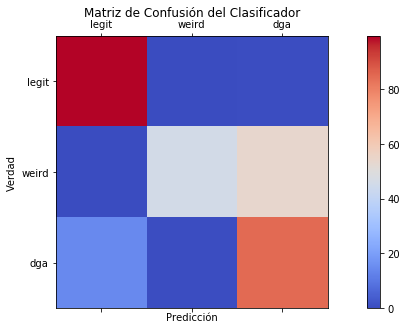

In [49]:
# Ahora graficamos los resultados del split 80/20 en una matriz de confusión
labels = ['legit', 'weird', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm, labels)

Parece funcionar ok, pero no queremos realmente crear un clasificador que tiene salidas para
tres clases. Lo que queremos es un clasificador que determine si un dominio es DGA o no (salida
binaria). Esta era una estrategia que parecía buena idea hasta que no lo era... :P

In [50]:
# Tal vez debemos excluir la clase weird durante el entrenamiento del modelo
not_weird = all_domains[all_domains['class'] != 'weird']
X = not_weird.as_matrix(['length', 'entropy', 'alexa_grams', 'word_grams'])

# Etiquetas (scikit-learn utiliza y como etiquetas de clasificación)
y = np.array(not_weird['class'].tolist())

# Entrenar el modelo con un split 80/20
#from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

/Users/hdemercado/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
# Ahora graficamos los resultados del split 80/20 en una matriz de confusión
labels = ['legit', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)
# plot_cm(cm, labels)

In [52]:
# Bueno, esto definitivamente luce mejor... pero hemos o no hecho trampa
# al remover los dominios raros (weird)? Tal vez, pero al menos de alguna forma
# estamos haciendo algo necesario. Remover muestras que son valores atípicos.
# Asi que para validar que el modelo esté haciendo lo correcto, vamos a 
# medir las predicciones del modelo en el set reservado para evaluación.

# Primero entrena utilizando toda la data, antes de ver su rendimiento
clf.fit(X, y)

# Crear el set de evaluación 
hold_out_domains = pd.concat([hold_out_alexa, hold_out_dga], ignore_index=True)

# Añadir un campo de longitud para cada dominio
hold_out_domains['length'] = [len(x) for x in hold_out_domains['domain']]
hold_out_domains = hold_out_domains[hold_out_domains['length'] > 6]

# Añadir un campo de entropía para cada dominio
hold_out_domains['entropy'] = [entropy(x) for x in hold_out_domains['domain']]

# Calcular número de coincidencias NGram para todos los dominios y añadirlo al dataframe
hold_out_domains['alexa_grams']= alexa_counts * alexa_vc.transform(hold_out_domains['domain']).T
hold_out_domains['word_grams']= dict_counts * dict_vc.transform(hold_out_domains['domain']).T

hold_out_domains.head()

domain  class  length   entropy  alexa_grams  word_grams
1         ultimatepay  legit      11  3.095795    41.309746   51.629444
2     administradores  legit      15  3.240224    63.485859   93.928801
3        kalabakacity  legit      12  2.751629    30.534363   44.499895
4  tropicaltraditions  legit      18  3.308271    71.565241  121.626720
5             ninikan  legit       7  1.842371    13.682808   19.672477

/Users/hdemercado/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Estadísticas de la Matriz de Confusión
legit/legit: 99.39% (6670/6711)
legit/dga: 0.61% (41/6711)
dga/legit: 14.98% (40/267)
dga/dga: 85.02% (227/267)


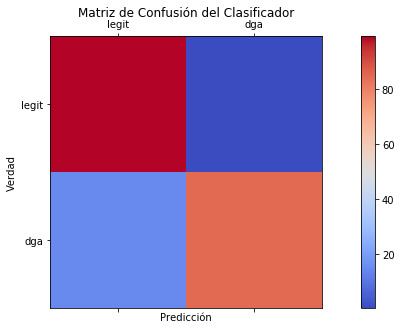

In [53]:
# Lista de vectores de características (scikit learn utiliza X como la matriz de vectores)
hold_X = hold_out_domains.as_matrix(['length', 'entropy', 'alexa_grams', 'word_grams'])
#hold_X = hold_out_domains.values(['length', 'entropy', 'alexa_grams', 'word_grams'])

# Labels (scikit learn uses 'y' for classification labels)
hold_y = np.array(hold_out_domains['class'].tolist())

# Ahora le pedimos al modelo que calcule las predicciones sobre el dataset de evaluación
hold_y_pred = clf.predict(hold_X)

# Añadir el arreglo de predicciones al dataframe
hold_out_domains['pred'] = hold_y_pred

# Ahora grafiquemos los resultados
labels = ['legit', 'dga']
cm = confusion_matrix(hold_y, hold_y_pred, labels)
plot_cm(cm, labels)

Text(0,0.5,'Número de Coincidencias de Alexa NGrams')

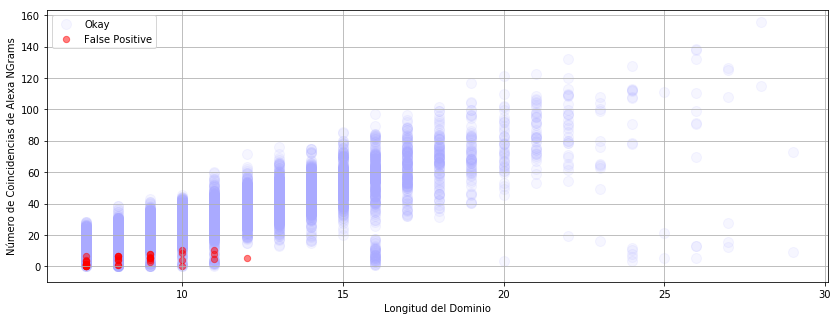

In [54]:
# Okay, en nuestro set de evaluación (hold out) de 10k dominios, unos ~100 fueron clasificados
# de forma equivocada. En este momento, hemos logrado buenos resultados y podemos declarar
# victoria. :) Siempre hay chance de mejorar, pero también debemos celebrar las victorias,
# aunque sean parciales. :)
#       - De los 10k dominios, 100 fueron clasificados erroneamente
#       - falsos positivos (dominios de Alexa clasificados como DGA) = ~0.6%
#       - cerca del 80% de los dominios de Alexa fueron clasificados correctamente

# Nota: Resultados sobre el 10% de evaluacion (100k dominios) del archivo completo (Alexa 1M)
# fueron similares a los de arriba
#       - De los 100k dominios, 432 fueron clasificados de forma incorrecta
#       - falsos positivos (dominios de Alexa clasificados como DGA) = 0.4%
#       - cerca del 70% de los dominios de Alexa fueron clasificados correctamente

# Ahora solo vamos a hacer un analisis sobre como se comporto el algoritmo de ML.

# Veamos un par de graficas para apreciar cuales dominios fueron clasificados de forma incorrecta
# Observemos Longitud vs Alexa NGrams
fp_cond = ((hold_out_domains['class'] == 'legit') & (hold_out_domains['pred']=='dga'))
fp = hold_out_domains[fp_cond]
fn_cond = ((hold_out_domains['class'] == 'dba') & (hold_out_domains['pred']=='legit'))
fn = hold_out_domains[fn_cond]
okay = hold_out_domains[hold_out_domains['class'] == hold_out_domains['pred']]
plt.scatter(okay['length'], okay['alexa_grams'], s=100,  c='#aaaaff', label='Okay', alpha=.1)
plt.scatter(fp['length'], fp['alexa_grams'], s=40, c='r', label='False Positive', alpha=.5)
plt.legend()
pylab.xlabel('Longitud del Dominio')
pylab.ylabel('Número de Coincidencias de Alexa NGrams')

Text(0,0.5,'Número de Coincidencias de Diccionarios NGram')

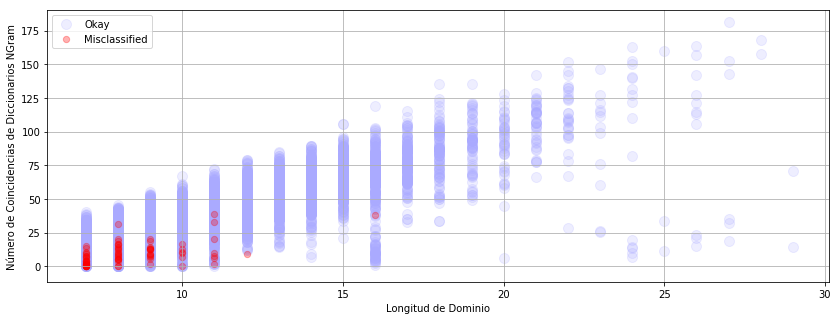

In [55]:
# Veámos longitud versus NGrams de Diccionarios
cond = (hold_out_domains['class'] != hold_out_domains['pred'])
misclassified = hold_out_domains[cond]
okay = hold_out_domains[~cond]
plt.scatter(okay['length'], okay['word_grams'], s=100,  c='#aaaaff', label='Okay', alpha=.2)
plt.scatter(misclassified['length'], misclassified['word_grams'], s=40, c='r', label='Misclassified', alpha=.3)
plt.legend()
pylab.xlabel('Longitud de Dominio')
pylab.ylabel('Número de Coincidencias de Diccionarios NGram')

In [56]:
misclassified.head()

domain  class  length   entropy  alexa_grams  word_grams pred
101  qqvip2010fb  legit      11  3.095795     4.934473    1.913814  dga
393      3181302  legit       7  2.235926     0.000000    0.000000  dga
501    lawrkhawm  legit       9  2.725481     7.735275   14.497829  dga
622    yeuamnhac  legit       9  2.947703     7.902482   12.706306  dga
642     blt17688  legit       8  2.750000     1.041393    0.000000  dga

In [57]:
misclassified[misclassified['class'] == 'dga'].head()

domain class  length   entropy  alexa_grams  word_grams   pred
9140  uolsugtlg   dga       9  2.503258     6.608778    9.346657  legit
9150  usbiezgac   dga       9  3.169925     7.812009    9.172547  legit
9151   ushcnewo   dga       8  3.000000    11.307197   13.904812  legit
9156    utamehz   dga       7  2.807355    10.791870   14.733893  legit
9158   utfowept   dga       8  2.750000     7.041879   16.814295  legit

In [58]:
importances_df = pd.DataFrame({'caracteristica': ['length', 'entropy', 'alexa_grams', 'word_grams'],
                               'importancia': list(clf.feature_importances_)})
importances_df

caracteristica  importancia
0         length     0.109204
1        entropy     0.170388
2    alexa_grams     0.516796
3     word_grams     0.203611

In [59]:
# Podemos también ver cuáles características (features) considera el algorítmo que son más
# importantes
importances_df = pd.DataFrame({'caracteristica': ['length', 'entropy', 'alexa_grams', 'word_grams'],
                               'importancia': list(clf.feature_importances_)})
importances_df.sort_values('importancia', axis=0, ascending=False, inplace=True)
importances_df

# De la lista de abajo, podemos ver las puntaciones sobre importancia de cada característica.
# Hay múltiples análisis que se pueden realizar para evaluar las características: feature selection,
# sensitivity study, etc.

caracteristica  importancia
2    alexa_grams     0.516796
3     word_grams     0.203611
1        entropy     0.170388
0         length     0.109204

In [62]:
def test_it(domain):
    _alexa_match = alexa_counts * alexa_vc.transform([domain]).T  # Woot matrix multiply and transpose Woo Hoo!
    _dict_match = dict_counts * dict_vc.transform([domain]).T
    _X = [len(domain), entropy(domain), _alexa_match, _dict_match]
    print (domain, clf.predict(_X)[0])

In [61]:
# Examples (feel free to change these and see the results!)
test_it('google')
test_it('google88')
test_it('facebook')
#test_it('1cb8a5f36f')
#test_it('pterodactylfarts')
#test_it('ptes9dro-dwacty2lfa5rrts')
#test_it('beyonce')
#test_it('bey666on4ce')
#test_it('supersexy')
#test_it('yourmomissohotinthesummertime')
#test_it('35-sdf-09jq43r')
#test_it('clicksecurity')

ValueError: Expected 2D array, got 1D array instead:
array=[ 6.         1.9182959 17.155428  14.870646 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Conclusiones:
La combinación de Jupyter Notebook, Pandas, Matplotlib y Scikit-Learn nos permitió preparar los datos, limpiarla, graficarla, comprenderla y consumirla con un algoritmo de machine learning! Muy cool!

Claramente se pueden probar muchas otras ideas: formalizar matemáticamente lo que hicimos, graficar curvas de aprendizaje (learning curves) para determinar que tanto puede aprender el modelo si le damos más data, ajustar el modelo para evitar el problema de 'overfitting', seleccionar mejores características de la data, etc, etc...

Existen muchos recursos gratuitos en el Internet para aprender más sobre machine learning, Pandas y Python. Recomiendo utilizar los tutoriales que están disponibles en https://pyvideo.org. Por ejemplo, puedes buscar las presentaciones
 - Pandas from the Ground Up, Brandon Rhodes: https://pyvideo.org/pycon-us-2015/pandas-from-the-ground-up.html
 - Pydata 101, Jake VanderPlas: https://pyvideo.org/pydata-seattle-2017/pydata-101.html
 - Machine Learning with Scikit Learn, Jake VanderPlas: https://pyvideo.org/pydata-seattle-2015/machine-learning-with-scikit-learn.html

Si estás interesado(a) en métodos para detectar dominios DGA, he aquí una lista de papers de investigaciónÑ
 - S. Yadav, A. K. K. Reddy, A. L. N. Reddy, and S. Ranjan, “Detecting algorithmically generated malicious domain names,” presented at the the 10th annual conference, New York, New York, USA, 2010, pp. 48–61. http://conferences.sigcomm.org/imc/2010/papers/p48.pdf
 - Kwon, J., Lee, J., Lee, H., & Perrig, A. (2016). PsyBoG: A scalable botnet detection method for large-scale DNS traffic. Computer Networks, 97, 48-73. https://ccs.korea.ac.kr/pds/COMNET16_KWON.pdf
 - Antonakakis, M., Perdisci, R., Nadji, Y., Vasiloglou, N., Abu-Nimeh, S., Lee, W., & Dagon, D. (2012, August). From Throw-Away Traffic to Bots: Detecting the Rise of DGA-Based Malware. In USENIX security symposium (Vol. 12). https://www.usenix.org/system/files/conference/usenixsecurity12/sec12-final127.pdf
 - Bilge, L., Kirda, E., Kruegel, C., & Balduzzi, M. (2011, February). EXPOSURE: Finding Malicious Domains Using Passive DNS Analysis. In Ndss. http://www.cs.ucsb.edu/~chris/research/doc/ndss11_exposure.pdf
 - Yadav, S., Reddy, A. K. K., Reddy, A. N., & Ranjan, S. (2012). Detecting algorithmically generated domain-flux attacks with DNS traffic analysis. IEEE/Acm Transactions on Networking, 20(5), 1663-1677. http://cesg.tamu.edu/wp-content/uploads/2012/04/reddy_papers/tnet12.pdf
 - Schiavoni, S., Maggi, F., Cavallaro, L., & Zanero, S. (2014, July). Phoenix: DGA-based botnet tracking and intelligence. In International Conference on Detection of Intrusions and Malware, and Vulnerability Assessment (pp. 192-211). Springer, Cham. https://www.syssec-project.eu/m/page-media/3/schiavoni-dimva14-phoenix.pdf